### class별로 데이터 나누기(초반 데이터 전처리)

In [1]:
# import os
# import shutil

# for i in range(5):
#     os.makedirs('./train_video/{}'.format(i), exist_ok = True)
# with open('./train.csv', 'r', encoding = 'utf-8-sig') as f:
#     f = f.read()
# train_info = f.split('\n')
# del train_info[0]
# del train_info[-1]
# for info in train_info:
#     info = info.split(',')
#     file_name = '{}.mp4'.format(info[0])
#     path = info[1]
#     cls = info[2]
#     shutil.copy(path, './train_video/{}/{}'.format(cls, file_name))

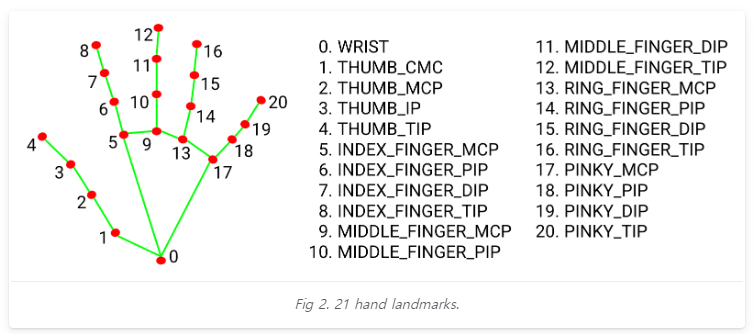

### 미디어로 train 동영상 모니터링

In [5]:
# import cv2
# import mediapipe as mp
# mp_drawing = mp.solutions.drawing_utils
# mp_drawing_styles = mp.solutions.drawing_styles
# mp_hands = mp.solutions.hands

# cv2.destroyAllWindows() 
# hands =  mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
# video_list = os.listdir('./train')
# for video_name in video_list:
#     cap = cv2.VideoCapture('./train/{}'.format(video_name))
#     if cap.isOpened():
#         while True:
#             ret, img = cap.read()
#             if ret == True:
#                 img = cv2.resize(img, (320, 320))
#                 results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#                 if not results.multi_hand_landmarks:
#                     continue
#                 for hand_landmarks in results.multi_hand_landmarks:
#                     mp_drawing.draw_landmarks(img,hand_landmarks,mp_hands.HAND_CONNECTIONS, 
#                                               mp_drawing_styles.get_default_hand_landmarks_style(), 
#                                               mp_drawing_styles.get_default_hand_connections_style())
#                 cv2.imshow('result', img)
#                 cv2.waitKey(1)
#             else: break

### MediaPipe로 LSTM데이터 추출

In [2]:
import os
import cv2
import mediapipe as mp
from tqdm import tqdm
import random

def mp_to_lstm(video_path, interval):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_hands = mp.solutions.hands
    hands =  mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)
    xy_list_list = []
    cv2.destroyAllWindows()
    cap = cv2.VideoCapture(video_path)
    if cap.isOpened():
        cnt = 0
        while True:
            ret, img = cap.read()
            if cnt == interval and ret == True:
                cnt = 0
                xy_list = []
                results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                if not results.multi_hand_landmarks: continue
                idx = 0
                for one_hand in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(img,one_hand,mp_hands.HAND_CONNECTIONS, 
                                              mp_drawing_styles.get_default_hand_landmarks_style(), 
                                              mp_drawing_styles.get_default_hand_connections_style())
                    for xy in one_hand.landmark:
                        xy_list.append(xy.x)
                        xy_list.append(xy.y)        
                xy_list_list.append(xy_list)
            elif ret == False: break
            cnt += 1
    cv2.destroyAllWindows()
    return xy_list_list

folder_list = os.listdir('./train_video')
dataset = []
for folder_name in folder_list:
    video_list = os.listdir('./train_video/{}'.format(folder_name))
    for video_name in tqdm(video_list):
        xy_list_list = mp_to_lstm('./train_video/{}/{}'.format(folder_name, video_name), 1)
        if len(xy_list_list) < 30 and len(xy_list_list) > 0:
            interval = 30 - len(xy_list_list)
            interval = interval / len(xy_list_list)
            full_list, cnt = [], 0
            for xy_list in xy_list_list:
                cnt += interval
                if cnt >= 1:
                    while True:
                        if cnt < 1: break
                        full_list.append(xy_list)
                        cnt -= 1
                full_list.append(xy_list)
        else:
            full_list = xy_list_list + []
        if len(full_list) > 29:
            while True:
                if len(full_list) == 29: break
                del full_list[-1]
        if len(full_list) == 29:
            dataset.append({'key': int(folder_name), 'value': full_list})
random.shuffle(dataset)
print(len(dataset))

 31%|█████████████████████████                                                        | 35/113 [00:44<01:26,  1.11s/it]

file name: TRAIN_211.mp4 | frame ea: 0


 14%|███████████▎                                                                     | 18/129 [00:21<02:06,  1.14s/it]

file name: TRAIN_074.mp4 | frame ea: 0


 22%|█████████████████▌                                                               | 28/129 [00:35<01:58,  1.17s/it]

file name: TRAIN_126.mp4 | frame ea: 0


 47%|██████████████████████████████████████▎                                          | 61/129 [01:19<01:12,  1.06s/it]

file name: TRAIN_278.mp4 | frame ea: 0


 53%|██████████████████████████████████████████▋                                      | 68/129 [01:28<01:09,  1.14s/it]

file name: TRAIN_312.mp4 | frame ea: 0


 40%|████████████████████████████████▏                                                | 48/121 [01:01<01:11,  1.03it/s]

file name: TRAIN_213.mp4 | frame ea: 0


 48%|██████████████████████████████████████▉                                          | 64/133 [01:21<01:12,  1.05s/it]

file name: TRAIN_284.mp4 | frame ea: 0


100%|████████████████████████████████████████████████████████████████████████████████| 114/114 [02:47<00:00,  1.47s/it]

603


In [3]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('현재 가상환경 GPU 사용 가능상태')
else:
    device = 'cpu'
    print('GPU 사용 불가능 상태')

현재 가상환경 GPU 사용 가능상태


In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list :
            self.y.append(dic['key'])
            self.X.append(dic['value'])
                
    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))
        
    def __len__(self):
        return len(self.X)

In [5]:
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(dataset) * split_ratio[0])
val_len = int(len(dataset) * split_ratio[1])
test_len = len(dataset) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

482, 60, 61


In [6]:
from torch.utils.data import random_split
train_dataset = MyDataset(dataset)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=8)
val_loader = DataLoader(valid_data, batch_size=8)
test_loader = DataLoader(test_data, batch_size=8)

In [7]:
class Transformer(nn.Module) :
    def __init__(self,out_channel):
        super(Transformer, self).__init__()
        
        self.out_channel = out_channel
        self.layerNorm = nn.LayerNorm(out_channel, 1e-6)
        self.multi_head_attn = Multi_Head_Attention(out_channel)
        self.feed_forward = Feed_Forward(out_channel)
        
    def forward(self, input_) :
        
        norm_input = self.layerNorm(input_)
        mha = self.multi_head_attn(norm_input)
        out = self.feed_forward(mha)
        return out
    
class Multi_Head_Attention(nn.Module) :
    def __init__(self,out_channel):
        super(Multi_Head_Attention, self).__init__()
        
        self.W_Q = nn.Linear(out_channel,out_channel)
        self.W_K = nn.Linear(out_channel,out_channel)
        self.W_V = nn.Linear(out_channel,out_channel)
        
        self.attn = Dot_Prod_Attention()
        
    def forward(self, input_) :
        
        Q = self.W_Q(input_)
        K = self.W_K(input_)
        V = self.W_V(input_)
        
        attention = self.attn(Q,K,V)
        
        return attention+input_
        
class Dot_Prod_Attention(nn.Module) :
    def __init__(self):
        super(Dot_Prod_Attention, self).__init__()
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, Q,K,V) :
        score = torch.matmul(Q,K.transpose(1,2))
        score = torch.matmul(score,V)
        attn = self.softmax(score)
        return attn
    
    
class Feed_Forward(nn.Module) :
    def __init__(self,out_channel):
        super(Feed_Forward, self).__init__()
        
        self.layerNorm = nn.LayerNorm(out_channel, 1e-6)
        self.fc1 = nn.Linear(out_channel,4*out_channel)
        self.fc2 = nn.Linear(4*out_channel,out_channel)
        
    def forward(self,multi_head_attn_out) :
        
        norm_out = self.layerNorm(multi_head_attn_out)
        out = F.gelu(self.fc1(norm_out))
        out = self.fc2(out)
        return out+multi_head_attn_out
    
class skeleton_Transformer(nn.Module) :
    def __init__(self,out_channel,num_class) :
        super(skeleton_Transformer,self).__init__()
        self.cls_tok = nn.Parameter(torch.randn(1,1,out_channel))
        self.linear_emb = nn.Linear(out_channel,out_channel)
        self.tranformer = nn.ModuleList([Transformer(out_channel) for _ in range(8)])
        self.classifier = nn.Linear(out_channel,num_class)
        
    def forward(self, x) :
        batch_size = x.shape[0]
        cls_toks = self.cls_tok.repeat(batch_size,1,1)
        emb_mat = self.linear_emb(x)
        x = torch.cat([cls_toks, emb_mat], dim=1)

        for encoder in self.tranformer :
            x = encoder(x)
        out = x[:,0,:]
        out = self.classifier(out)
        return out

In [8]:
# 모델 초기화
import matplotlib.pyplot as plt
from torch.optim import Adam
def init_model():
    plt.rc('font', size = 10)
    global net, loss_fn, optim
    net = skeleton_Transformer(42, 5).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=0.0001)
    
# epoch 카운터 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0
    
def init_log():
    plt.rc('font', size = 10)
    # 모든 Log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

In [9]:
import gc
from torch.cuda import memory_allocated, empty_cache
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
import numpy as np
def epoch(data_loader, mode = 'train'):
    global epoch_cnt
    
    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False
    
    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-forward
        if mode == 'train':
            net.train()
        else:
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            net.eval()

        result = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출
        
        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록
        
        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기르 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문 나가면 epoch 카운터 += 1
            
        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TN)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록
        
    # 역전파 학습 후 Epoch 카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1
    
    clear_memory()
    
    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

In [10]:
def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
    
def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

from IPython.display import clear_output
def print_log():
    # 학습 추이 출력
    
    # 소숫점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)
    
    log_str = 'Epoch: {:3} | T_Loss {:5} | T_acc {:5} | V_Loss {:5} | V_acc. {:5} | \
🕒 {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)
    
    log_stack.append(log_str) # 프린트 준비
    
    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정
    
    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')
    
    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')
    
    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line # 위에서 선언한 plt정보들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid() # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()
    
    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))): # 반대로 sort 시켜서 출력
        print(log_stack[idx])

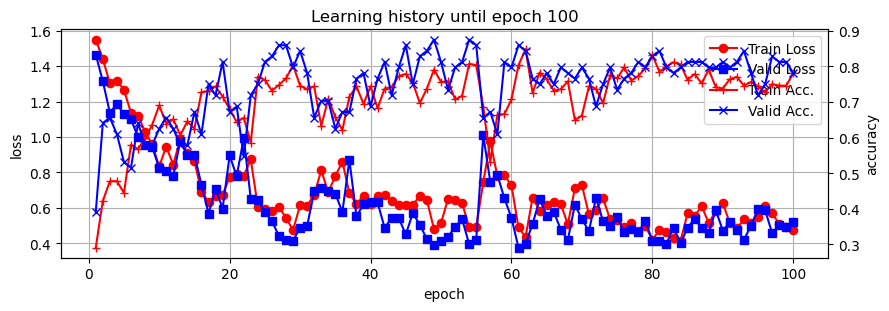

Epoch: 100 | T_Loss 0.478 | T_acc 0.781 | V_Loss 0.518 | V_acc. 0.781 | 🕒 1.587
Epoch:  99 | T_Loss 0.491 | T_acc 0.746 | V_Loss 0.495 | V_acc. 0.812 | 🕒 1.691
Epoch:  98 | T_Loss 0.509 | T_acc 0.746 | V_Loss 0.502 | V_acc. 0.812 | 🕒 1.578
Epoch:  97 | T_Loss 0.571 | T_acc  0.75 | V_Loss 0.458 | V_acc. 0.828 | 🕒 1.548
Epoch:  96 | T_Loss 0.611 | T_acc 0.727 | V_Loss 0.587 | V_acc.  0.75 | 🕒 1.611
Epoch:  95 | T_Loss 0.546 | T_acc 0.744 | V_Loss 0.593 | V_acc. 0.719 | 🕒 1.559
Epoch:  94 | T_Loss 0.516 | T_acc 0.756 | V_Loss   0.5 | V_acc. 0.781 | 🕒 1.551
Epoch:  93 | T_Loss 0.535 | T_acc 0.746 | V_Loss  0.42 | V_acc. 0.844 | 🕒 1.569
Epoch:  92 | T_Loss 0.485 | T_acc  0.77 | V_Loss 0.476 | V_acc. 0.812 | 🕒 1.593
Epoch:  91 | T_Loss 0.514 | T_acc 0.764 | V_Loss 0.519 | V_acc. 0.797 | 🕒 1.574
Epoch:  90 | T_Loss 0.626 | T_acc 0.738 | V_Loss 0.472 | V_acc. 0.812 | 🕒 1.575
Epoch:  89 | T_Loss 0.583 | T_acc 0.742 | V_Loss 0.587 | V_acc. 0.797 | 🕒 1.651
Epoch:  88 | T_Loss 0.514 | T_acc 0.791 

In [11]:
# Training Initialization
init_model()
init_epoch()
init_log()
maximum_epoch = 100

# Training Iteration
import time
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

In [12]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc.: 0.7125
Test Loss: 0.5728


### Test 데이터 투입

In [13]:
import natsort
video_list = os.listdir('./test')
video_list = natsort.natsorted(video_list)
id_list, label_list = ['id'], ['label']
pred_class = 0
for video_name in tqdm(video_list):
    xy_list_list = mp_to_lstm('./test/{}'.format(video_name), 1)
    if len(xy_list_list) < 30 and len(xy_list_list) > 0:
        interval = 30 - len(xy_list_list)
        interval = interval / len(xy_list_list)
        full_list, cnt = [], 0
        for xy_list in xy_list_list:
            cnt += interval
            if cnt >= 1:
                while True:
                    if cnt < 1: break
                    full_list.append(xy_list)
                    cnt -= 1
            full_list.append(xy_list)
    else:
        full_list = xy_list_list + []
    if len(full_list) > 29:
        while True:
            if len(full_list) == 29: break
            del full_list[-1]
    if len(full_list) == 29:
        dataset = []
        dataset.append({'key': int(folder_name), 'value': full_list})
        dataset = MyDataset(dataset)
        dataset = DataLoader(dataset)
        for data, label in dataset:
            data = data.to(device)
            with torch.no_grad():
                result = net(data)
                _, out = torch.max(result, 1)
                pred_class = out.item()
            id_list.append(video_name.split('.')[0])
            label_list.append(pred_class)
    else:
        id_list.append(video_name.split('.')[0])
        label_list.append(pred_class)
        print('len: {} | file name: {}'.format(len(full_list), video_name))

  6%|██▌                                        | 9/153 [00:10<02:33,  1.07s/it]

len: 0 | file name: TEST_008.mp4


  8%|███▎                                      | 12/153 [00:14<02:21,  1.01s/it]

len: 0 | file name: TEST_011.mp4


 54%|██████████████████████▊                   | 83/153 [01:41<01:14,  1.06s/it]

len: 0 | file name: TEST_082.mp4


 95%|███████████████████████████████████████  | 146/153 [02:59<00:07,  1.11s/it]

len: 0 | file name: TEST_145.mp4


100%|█████████████████████████████████████████| 153/153 [03:09<00:00,  1.24s/it]


### 제출 csv 만들기

In [25]:
with open('./result.csv', 'w', encoding = 'utf-8-sig') as f:
    cnt = 0
    for i, j in zip(id_list, label_list):
        if cnt == len(id_list) - 1:
            f.write('{},{}'.format(i, j))
            print('csv 저장 완료')
        else:
            f.write('{},{}\n'.format(i, j))
        cnt += 1

csv 저장 완료
